# Analýza dat slonů

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.gridspec as gridspec
from scipy.stats import mode
import os
import sys

# PATH TRICK
sys.path.append('..')
from visualize.read_positions import read_positions



In [3]:
plt.rcParams.update({
    "font.family": "serif",
    "pgf.texsystem": "lualatex",
    "pgf.rcfonts": False,
    "savefig.edgecolor": "ffffff",
    "savefig.facecolor": "ffffff",
    "figure.figsize": (6, 3.75),
    "font.size": "10"
})
save=True
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper" if save else "notebook")

sns.set_style("whitegrid")

palette = sns.color_palette("hls", 5)
sns.set_palette(palette)

In [4]:
df = read_positions(label_dir='../../data_all/labels', output_csv='positions.csv')

# Exclude for consistency
dates_to_exclude = [pd.to_datetime('2024-01-21').date(), pd.to_datetime('2024-01-22').date(), pd.to_datetime('2024-01-23').date()]

df = df[~df['Date'].dt.date.isin(dates_to_exclude)]
df.head(11)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 8087
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Camera    7720 non-null   int64         
 1   Date      7720 non-null   datetime64[ns]
 2   X_center  7720 non-null   float64       
 3   Y_center  7720 non-null   float64       
 4   Width     7720 non-null   float64       
 5   Height    7720 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 422.2 KB


In [5]:
df.drop(columns=['X_center', 'Y_center', 'Width' , 'Height'], inplace=True)

### Rozložení počtu slonů 

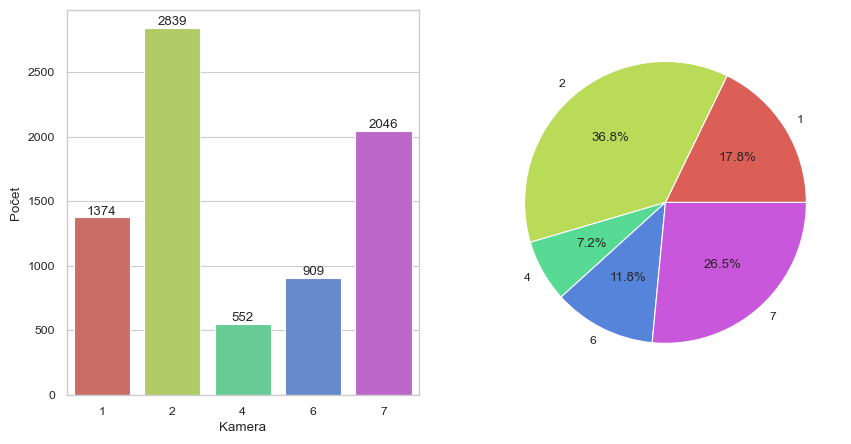

In [6]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# title =  'Analysis of elephants in from given cameras'
# fig.suptitle(title, fontsize = 18)
sns.countplot(data=df, x='Camera', ax=ax1, palette=palette, hue='Camera')

for container in ax1.containers:
    ax1.bar_label(container)
ax1.set_xlabel('Kamera')
ax1.set_ylabel('Počet')

ax1.legend().set_visible(False)

value_counts = df['Camera'].value_counts(normalize=True).sort_index()
labels = value_counts.index

ax2.pie(value_counts, labels=labels, autopct='%1.1f%%')
plt.savefig('counts.pdf', bbox_inches="tight") 

plt.show()

### Průměrné Množství slonů na jednotlivých kamerách podle hodiny

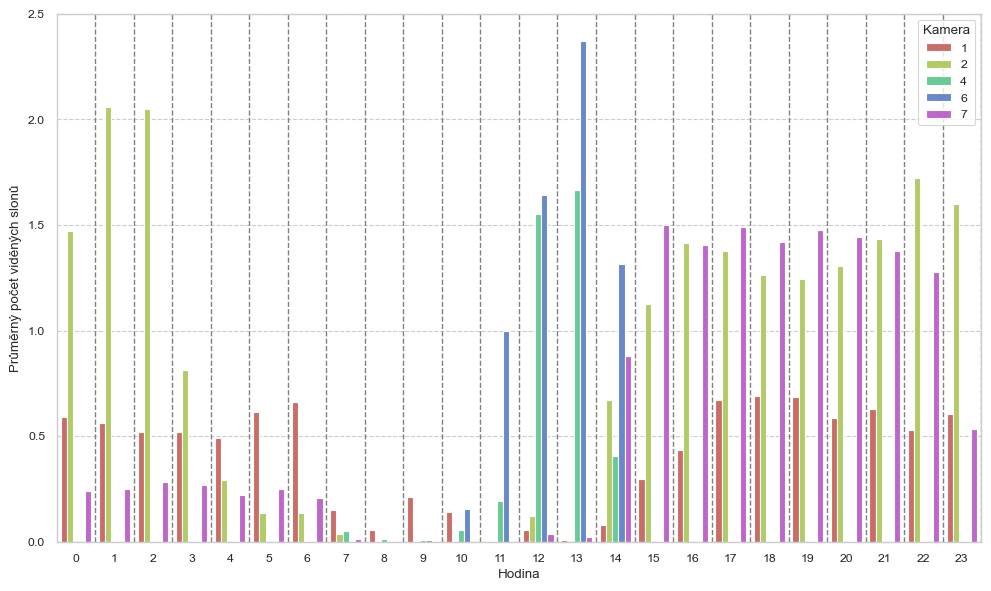

In [7]:
df['Hour'] = df['Date'].dt.hour
num_days = df['Date'].dt.date.nunique()
hourly_sightings = df.groupby(['Hour', 'Camera']).size().unstack(fill_value=0) / num_days /4

melted = hourly_sightings.reset_index().melt(id_vars='Hour', var_name='Camera', value_name='Average Sightings')

# Adjusting the graph with wider separators
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour', y='Average Sightings', hue='Camera', data=melted, dodge=True, palette=sns.color_palette("hls", len(hourly_sightings.columns)))
for hour in range(0, 24):
    plt.axvline(x=hour + 0.5, color='grey', linestyle='--', linewidth=1)

# plt.title('Average Elephant Sightings by Hour of the Day per Camera')
plt.xlabel('Hodina')
plt.ylabel('Průměrný počet viděných slonů')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.legend(title='Kamera', loc='upper right')
plt.yticks(np.arange(0,3,0.5))

plt.tight_layout()
plt.savefig('average_counts.pdf', bbox_inches="tight") 

plt.show()


### Maximální průměrné množství slonů pro každou hodinu podle dne v týdnu.
Každý sloupec v časovém okně představuje jeden den od pondělí do neděle.
Z grafu se dá vykoukat jistá variabilita v rámci jednotlivých dnů.

/var/folders/tl/h1jkjn_97773_b51y3fb7cfw0000gn/T/ipykernel_33904/3436322523.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_camera = df.groupby(['Hour', 'Weekday', 'Camera']).size().reset_index(name='Sightings')
/var/folders/tl/h1jkjn_97773_b51y3fb7cfw0000gn/T/ipykernel_33904/3436322523.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_avg_sightings = grouped_by_camera.loc[grouped_by_camera.groupby(['Hour', 'Weekday'])['Average Sightings Per Day'].idxmax()]


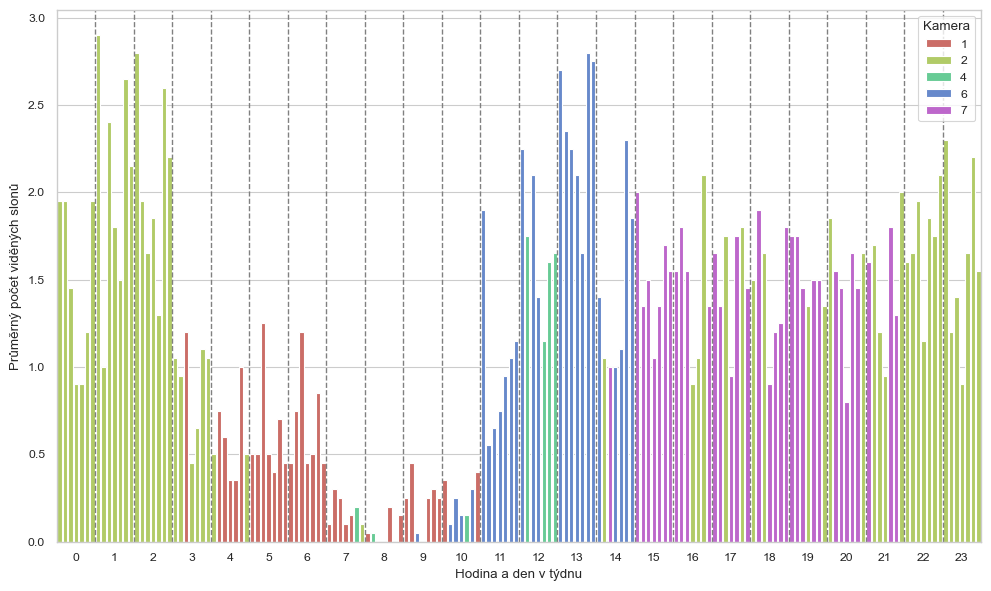

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preparation steps
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = df['Date'].dt.hour
df['Weekday'] = df['Date'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)

grouped_by_camera = df.groupby(['Hour', 'Weekday', 'Camera']).size().reset_index(name='Sightings')

weeks = 5
grouped_by_camera['Average Sightings Per Day'] = grouped_by_camera['Sightings'] / weeks /4

max_avg_sightings = grouped_by_camera.loc[grouped_by_camera.groupby(['Hour', 'Weekday'])['Average Sightings Per Day'].idxmax()]

max_avg_sightings['Hour-Weekday'] = max_avg_sightings['Hour'].astype(str) + '-' + max_avg_sightings['Weekday'].astype(str)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour-Weekday', y='Average Sightings Per Day', hue='Camera', data=max_avg_sightings, dodge=False, palette=sns.color_palette("hls", df['Camera'].nunique()))

unique_hours = sorted(max_avg_sightings['Hour'].unique())
# Shift for labels
label_positions = [(unique_hours.index(hour) * 7 + 3) for hour in unique_hours] 

plt.xticks(ticks=label_positions, labels=unique_hours, rotation=90)

for pos in label_positions[:-1]:  
    plt.axvline(x=pos + 3.5, color='grey', linestyle='--', linewidth=1) 

# plt.title('Average Sightings per Day by Hour and Weekday, Colored by Camera')
plt.xlabel('Hodina a den v týdnu')
plt.ylabel('Průměrný počet viděných slonů')
# plt.xlabel('Hour and Weekday')
# plt.ylabel('Average Sightings Per Day')
plt.xticks(rotation=0)

plt.legend(title='Kamera', loc='upper right')
plt.tight_layout()
plt.savefig('week.pdf', bbox_inches="tight") 

plt.show()


### Testové statistiky
Na základě daných grafů je dobré ověřit jisté testové statistiky

In [9]:
import scipy.stats as stats
data = df.copy()

#### **Testování nezávisloti výskytu slonů na kamerách v závislosti na čase**

In [15]:

data['Hour'] = data['Date'].dt.hour

hour_camera_contingency = pd.crosstab(data['Hour'], data['Camera'], margins=True)
hour_camera_contingency = hour_camera_contingency
hour_camera_contingency

Camera,1,2,4,6,7,All
Hour,,,,,,
0,83,206,0,0,34,323
1,79,288,0,0,35,402
2,73,287,0,0,40,400
3,73,114,0,0,38,225
4,69,41,0,0,31,141
5,86,19,0,0,35,140
6,93,19,0,0,29,141
7,21,5,7,0,2,35
8,8,0,2,0,0,10


Provedeme Pearsonův $\chi^2$ test nezávislosti s hladinou významnosti 5 %.

- $H_0$:  Každý řádek je realizací téhož rozdělení.
- $H_A$:  neplatí $H_0$


In [16]:
chi2_stat, p_val, dof, expected = stats.chi2_contingency(hour_camera_contingency)

print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-Value: {p_val}')
print(f'Degrees of Freedom: {dof}')

Chi-Square Statistic: 8457.729899694688
P-Value: 0.0
Degrees of Freedom: 120


0.0

Na standardní hladině zamítáme ve prospěch alternativy, tedy výskyt slonů je významně ovlivněný časovou dobu.

#### **Testování nezávisloti výskytu slonů venku a vevnitř v závislosti na čase**
Opět využití Pearsonova $\chi^2$ testu.

- $H_0$:  Každý řádek je realizací téhož rozdělení.
- $H_A$:  neplatí $H_0$

In [18]:
data['Location'] = data['Camera'].apply(lambda x: 'Outside' if x in [4, 6] else 'Inside')

hour_camera_contingency = pd.crosstab(data['Hour'], data['Location'], margins=True)
hour_camera_contingency = hour_camera_contingency

chi2_stat, p_val, dof, expected = stats.chi2_contingency(hour_camera_contingency)
print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-Value: {p_val}')
print(f'Degrees of Freedom: {dof}')

Chi-Square Statistic: 6609.94348868855
P-Value: 0.0
Degrees of Freedom: 48


Na standardní hladině zamítáme ve prospěch alternativy, tedy venku či vevnitř je významně ovlivněný časovou dobu.

#### **Testování hypotézy, zda jich je slonů mezi $12-14$ významně více venku**

Agregujeme si do tabulky dvě veličiny počtu slonů viděných na vnitřních kamerách oproti počtu ve venkovních.

Použití párového t-testu vyžaduje normalitu rozdílů sledovaných veličin.

Použijeme Shapiro-Wilkův test pro ověření hypotézy o normalitě.

- $H_0$: Rozdíl veličin pochází z náhodného rozdělení
- $H_A$: neplatí $H_0$

In [13]:
filtered_data = data[(data['Hour'] >= 12) & (data['Hour'] < 14)]
grouped_data = data.groupby([filtered_data['Date'], 'Location']).size().unstack(fill_value=0)
w_stat, p_val = stats.shapiro(grouped_data['Inside'] - grouped_data['Outside'])

print("W-Statistic:", w_stat)
print("P-Value:", p_val)

W-Statistic: 0.8964443398766632
P-Value: 3.0252688940034446e-11


Na standardní hladině zamítáme normalitu rozdílu daných veličin.
Místo párového t-testu využijeme jeho neparametrickou verzi tedy párový Wilcoxonův test.

- $H_0$: $EZ = 0$
- $H_A$: $EZ < 0$

In [14]:
adjusted_t_stat, adjusted_p_val = stats.wilcoxon(grouped_data['Inside'], grouped_data['Outside'], alternative='less')  

print("Adjusted T-Statistic:", adjusted_t_stat)
print("Adjusted P-Value:", adjusted_p_val)

Adjusted T-Statistic: 214.0
Adjusted P-Value: 3.3131167887357384e-37


Na standardní hladině zamitáme ve prospěch alt., tedy slonů je venku mezi 12-14 významně více.